In [1]:
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
!unzip -q "archive.zip"

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(42)

In [4]:
# Creating the Pathlib PATH objects
train_path= Path("chest_xray/train/")
test_path= Path("chest_xray/test")
valid_path= Path("chest_xray/val")

In [5]:
"""Accessing all the files inside the "Normal" and "Pneumonia" folders of the above paths
(returns all files that are two layers below the path)"""
train_image_paths = train_path.glob("*/*")
val_image_paths = valid_path.glob("*/*")

# The output is a generator object
print(train_image_paths)

<generator object Path.glob at 0x7b2ebfd8b060>


In [6]:
# Converting the generator object to a list of elements (the outputs are PosiPath objects)
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

print(train_image_paths[:6])

[PosixPath('chest_xray/train/PNEUMONIA/person50_bacteria_238.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person1477_virus_2561.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person259_virus_540.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person267_virus_552.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person74_bacteria_363.jpeg'), PosixPath('chest_xray/train/PNEUMONIA/person449_bacteria_1939.jpeg')]


In [7]:
# Converting the paths from PosiPath objects to strings
train_image_paths = list(map(lambda x: str(x), train_image_paths))
val_image_paths = list(map(lambda x: str(x), val_image_paths))

print(train_image_paths[:6])
print(val_image_paths[:6])

['chest_xray/train/PNEUMONIA/person50_bacteria_238.jpeg', 'chest_xray/train/PNEUMONIA/person1477_virus_2561.jpeg', 'chest_xray/train/PNEUMONIA/person259_virus_540.jpeg', 'chest_xray/train/PNEUMONIA/person267_virus_552.jpeg', 'chest_xray/train/PNEUMONIA/person74_bacteria_363.jpeg', 'chest_xray/train/PNEUMONIA/person449_bacteria_1939.jpeg']
['chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg', 'chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg', 'chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg', 'chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg', 'chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg', 'chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg']


In [8]:
# Store lengths of training and validation sets
train_length = len(train_image_paths)
val_length = len(val_image_paths)
print("training set length: ",train_length, ", validation set length: ", val_length)

training set length:  5216 , validation set length:  16


In [9]:
# Assigning labels to each class of images
labels ={"NORMAL":0, "PNEUMONIA":1}
inv_labels={0:"NORMAL", 1:"PNEUMONIA"}

def get_label(path : str) -> int:
  return labels[path.split("/")[-2]]

train_labels = list(map(lambda x: get_label(x), train_image_paths))
val_labels = list(map(lambda x: get_label(x), val_image_paths))

print(train_labels[:6])

[1, 1, 1, 1, 1, 1]


In [10]:
# Data transformation

BATCH_SIZE = 32

def load_and_transform(image, label, train= True):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [224, 224], method="nearest")
  if train:
    image = tf.image.random_flip_left_right(image)
    return image, label

In [11]:
# Creating a tensorflow data object

def get_dataset(paths, labels, train= True):
  image_paths = tf.convert_to_tensor(paths)
  labels = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  label_dataset = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((image_dataset, label_dataset)).shuffle(1000)

  dataset = dataset.map(lambda image, label: load_and_transform(image, label, train))
  dataset = dataset.repeat()
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE)

  return dataset

In [12]:
# Testing the training data object
%time train_dataset = get_dataset(train_image_paths, train_labels)
image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 1.2 s, sys: 222 ms, total: 1.42 s
Wall time: 2.79 s
(32, 224, 224, 3)
(32,)


PNEUMONIA


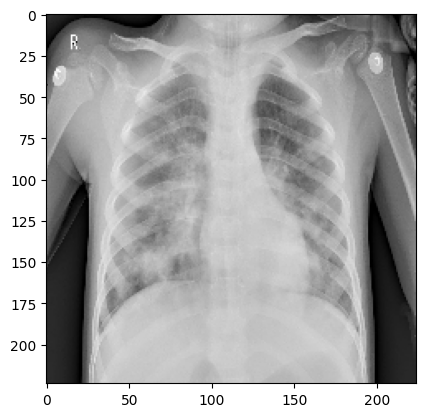

In [13]:
# Viewing a sample train image
print(inv_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [14]:
# Testing the validation data object
%time val_dataset = get_dataset(val_image_paths, val_labels)

image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 37.1 ms, sys: 821 µs, total: 37.9 ms
Wall time: 42.8 ms
(32, 224, 224, 3)
(32,)


In [15]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape= (224, 224, 3),
    include_top= False
)
model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation= "sigmoid")
])

model.summary()

94668760/94668760 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 23521409 (89.73 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [16]:
# Compiling the model by providing the optimizer, loss, and metrics
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001, beta_1= 0.9,beta_2=0.999, epsilon=1e-07),
    loss= "binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(name="precision"),tf.keras.metrics.Recall(name="recall")]
)

In [17]:
# Defining Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weight.h5",verbose=1, save_best_only=True, save_weights_only=True)
early_stop= tf.keras.callbacks.EarlyStopping(patience=4)

In [18]:
print(train_length//BATCH_SIZE)
print(val_length//BATCH_SIZE)
print(4//3)
print(train_length)
print(val_length)

163
0
1
5216
16


In [19]:
# Training the model
history = model.fit(
    train_dataset,
    steps_per_epoch= train_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint, early_stop],
    validation_data= val_dataset,
    #validation_steps= val_length//BATCH_SIZE
    validation_steps= 1
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9302 - precision: 0.9539 - recall: 0.9598
Epoch 1: val_loss improved from inf to 275.10355, saving model to best_weight.h5
163/163 [==============================] - 121s 464ms/step - loss: 0.1907 - accuracy: 0.9302 - precision: 0.9539 - recall: 0.9598 - val_loss: 275.1035 - val_accuracy: 0.4375 - val_precision: 0.4375 - val_recall: 1.0000
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9636 - precision: 0.9742 - recall: 0.9772
Epoch 2: val_loss improved from 275.10355 to 2.09428, saving model to best_weight.h5
163/163 [==============================] - 79s 485ms/step - loss: 0.0974 - accuracy: 0.9636 - precision: 0.9742 - recall: 0.9772 - val_loss: 2.0943 - val_accuracy: 0.5938 - val_precision: 0.6667 - val_recall: 0.2667
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9726 - precision: 0.9808 - recall: 0.9821
Epo

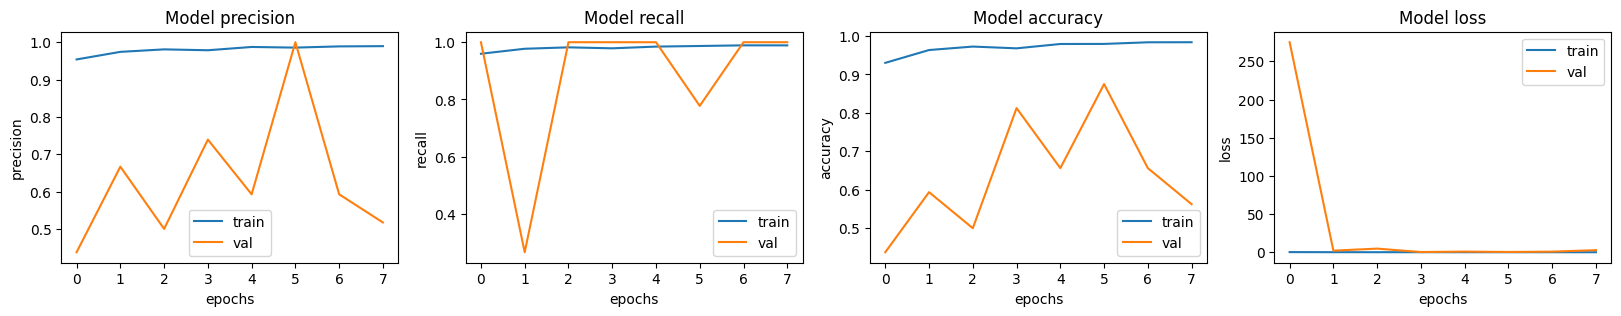

In [20]:
# Interpreting the model's metrics
fig, ax= plt.subplots(1,4, figsize=(20,3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history["val_"+ met])
  ax[i].set_title("Model {}".format(met))
  ax[i].set_xlabel("epochs")
  ax[i].set_ylabel(met)
  ax[i].legend(["train", "val"])

In [21]:
# Saving the best model
# Loading the best weights
model.load_weights("best_weight.h5")
# saving the model weights and architecture
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
loaded_model= tf.keras.models.load_model("model.h5")

In [23]:
# Creating a test dataset
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x: str(x), test_image_paths))
test_labels = list(map(lambda x: get_label(x), test_image_paths))
test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image, label):
  image= tf.io.read_file(image)
  image= tf.io.decode_jpeg(image, channels=3)
  image= tf.image.resize(image, [224, 224], method="nearest")
  return image, label

test_dataset=(
    tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [24]:
# Verifyiing the test dataset object
image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


PNEUMONIA


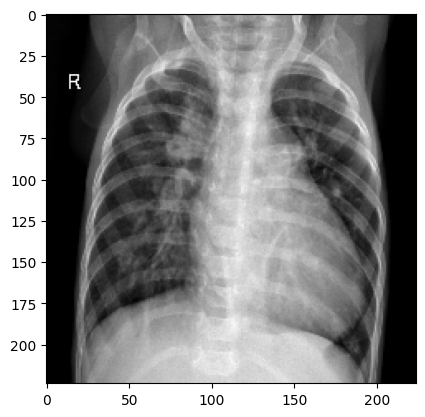

In [25]:
# Viewing a sample validation image
print(inv_labels[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224,224,3))

In [26]:
# Evaluatiing the model on the test dataset
loss, acc, prec, rec= loaded_model.evaluate(test_dataset)

print("Testing accuracy: ", acc)
print("Testing precision: ", prec)
print("Testing recall: ", rec)

20/20 [==============================] - 7s 298ms/step - loss: 1.4828 - accuracy: 0.7532 - precision: 0.7210 - recall: 0.9872
Testing accuracy:  0.7532051205635071
Testing precision:  0.720973789691925
Testing recall:  0.9871794581413269
